# Here we will train and test GPR and RFR on the same quiet + noisy data

THe two should be the same on everything besides the fitting method

In [19]:
# Set up
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared, DotProduct, Matern, WhiteKernel
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.decomposition import PCA

from sklearn.linear_model import Lasso, LinearRegression
from sklearn.linear_model import Ridge

from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.preprocessing import StandardScaler as SS

from sklearn.model_selection import train_test_split as tts

from IPython.display import clear_output
from datetime import datetime as dt
import time

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import random

#  Standardize the data

In [2]:
# Data from GitHub
url = 'https://raw.githubusercontent.com/benkim1226/footballdata/master/simulated_data_1000.csv'
data = pd.read_csv(url, index_col = 0)

# Standardization
scaler = StandardScaler()
data = scaler.fit_transform(data)
data = pd.DataFrame(data)

In [3]:
# Create noisy_data
noisy_data = pd.read_csv(url, index_col = 0)
noisy_data['noise'] = list(np.random.normal(0,1,1000))

noisy_data = scaler.fit_transform(noisy_data)
noisy_data = pd.DataFrame(noisy_data)

In [4]:
def add_noise(df,noise_columns):
  '''
  this function adds a certain number of noise columns to the existing dataframe
  '''

  df_copy = df.copy()

  for i in range(0,noise_columns):

    df_copy['noise'+str(i)] = np.random.normal(0,1,len(df_copy))

  return(df_copy)


def standardizer(df):
  df_copy = df.copy()

  scaler = StandardScaler()
  df_copy = scaler.fit_transform(df_copy)
  df_copy = pd.DataFrame(df_copy)
  return(df_copy)

# ATTEMPT NUMBER 2

Successful (June 28)

Takes 2 min to run

In [5]:
LHS_url = 'https://raw.githubusercontent.com/benkim1226/footballdata/master/LHS_complete.csv'
LHS_data = pd.read_csv(LHS_url, index_col = 0)
LHS_data = LHS_data.reset_index()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_LHS = scaler.fit_transform(LHS_data)
scaled_LHS = pd.DataFrame(scaled_LHS)

In [8]:
constant = 1
kernel = constant * RBF(length_scale= 1.0 , length_scale_bounds=(1e-3, 1e3))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y = True)

n = 100
rfr = RFR(n_estimators = n)

lasso = Lasso(alpha = 0.25)

linear = LinearRegression()


In [26]:
sample_sizes = list(np.around((np.logspace(1.5, 2.7, 20)),0)) # USE LOGISTICAL SAMPLE SIZES
sample_sizes = [int(x) for x in sample_sizes]

noise = 0 # n of noise columns
stats = {}

def compare(*models):
  """
  This function iterates through a tuple of sample_sizes to see MAE differences between those ML methods.

  Parameters

  Methods: 'RFR' / 'GPR' / 'Linear' / 'Lasso'

  Noise: # of noise variables

  """

  func_data = LHS_data.copy()
  func_data = func_data.drop('simulation_values',axis=1)
  func_data = add_noise(func_data,noise)

  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()

  func_data = scaler.fit_transform(func_data)
  func_data = pd.DataFrame(func_data)

  print(func_data.head())

  for i in models:
    stats["{0}".format(i)] = {'MAE_train':[],'MAE_test':[],'MSE_train':[],'MSE_test':[],'R2_train':[],'R2_test':[]}

  print(stats.keys())

  # Changing keys for readability
  if 'GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),\n                         n_restarts_optimizer=9, normalize_y=True)' in stats:
    stats['gpr'] = stats['GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),\n                         n_restarts_optimizer=9, normalize_y=True)']
    del stats['GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),\n                         n_restarts_optimizer=9, normalize_y=True)']

  if 'RandomForestRegressor()' in stats:
    stats['rfr'] = stats['RandomForestRegressor()']
    del stats['RandomForestRegressor()']

  if 'Lasso(alpha=0.25)' in stats:
    stats['lasso'] = stats['Lasso(alpha=0.25)']
    del stats['Lasso(alpha=0.25)']

  if 'LinearRegression()' in stats:
    stats['linear'] = stats['LinearRegression()']
    del stats['LinearRegression()']

  print(stats.keys())

  for s in sample_sizes:
    indexes = random.sample(range(0, len(func_data)), s)

    sample_data = func_data.loc[indexes]
    sample_y = LHS_data['simulation_values'].loc[indexes]

    X = sample_data
    y = sample_y

    print("TTS'ing")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    print("TTS'ing complete")

    for model in models:

      model.fit(X_train, y_train)

      if str(type(model)) == "<class 'sklearn.gaussian_process._gpr.GaussianProcessRegressor'>":
        stats['gpr']['MAE_train'] += [mean_absolute_error(y_train, model.predict(X_train))]
        stats['gpr']['MAE_test'] += [mean_absolute_error(y_test, model.predict(X_test))]
        stats['gpr']['MSE_train'] += [mean_squared_error(y_train, model.predict(X_train))]
        stats['gpr']['MSE_test'] += [mean_squared_error(y_test, model.predict(X_test))]
        stats['gpr']['R2_train'] += [r2_score(y_train, model.predict(X_train))]
        stats['gpr']['R2_test'] += [r2_score(y_test, model.predict(X_test))]

        print("s: "+str(s)+ " | GPR MAE: "+str(mean_absolute_error(y_test, model.predict(X_test))))

      if str(type(model)) == "<class 'sklearn.ensemble._forest.RandomForestRegressor'>":
        stats['rfr']['MAE_train'] += [mean_absolute_error(y_train, model.predict(X_train))]
        stats['rfr']['MAE_test'] += [mean_absolute_error(y_test, model.predict(X_test))]
        stats['rfr']['MSE_train'] += [mean_squared_error(y_train, model.predict(X_train))]
        stats['rfr']['MSE_test'] += [mean_squared_error(y_test, model.predict(X_test))]
        stats['rfr']['R2_train'] += [r2_score(y_train, model.predict(X_train))]
        stats['rfr']['R2_test'] += [r2_score(y_test, model.predict(X_test))]

        print("s: "+str(s)+ " | RFR MAE: "+str(mean_absolute_error(y_test, model.predict(X_test))))

      if str(type(model)) == "<class 'sklearn.linear_model._coordinate_descent.Lasso'>":
        stats['lasso']['MAE_train'] += [mean_absolute_error(y_train, model.predict(X_train))]
        stats['lasso']['MAE_test'] += [mean_absolute_error(y_test, model.predict(X_test))]
        stats['lasso']['MSE_train'] += [mean_squared_error(y_train, model.predict(X_train))]
        stats['lasso']['MSE_test'] += [mean_squared_error(y_test, model.predict(X_test))]
        stats['lasso']['R2_train'] += [r2_score(y_train, model.predict(X_train))]
        stats['lasso']['R2_test'] += [r2_score(y_test, model.predict(X_test))]

        print("s: "+str(s)+ " | LASSO MAE: "+str(mean_absolute_error(y_test, model.predict(X_test))))

      if str(type(model)) == "<class 'sklearn.linear_model._base.LinearRegression'>":
        stats['linear']['MAE_train'] += [mean_absolute_error(y_train, model.predict(X_train))]
        stats['linear']['MAE_test'] += [mean_absolute_error(y_test, model.predict(X_test))]
        stats['linear']['MSE_train'] += [mean_squared_error(y_train, model.predict(X_train))]
        stats['linear']['MSE_test'] += [mean_squared_error(y_test, model.predict(X_test))]
        stats['linear']['R2_train'] += [r2_score(y_train, model.predict(X_train))]
        stats['linear']['R2_test'] += [r2_score(y_test, model.predict(X_test))]

        print("s: "+str(s)+ " | LINEAR MAE: "+str(mean_absolute_error(y_test, model.predict(X_test))))

  return stats

In [ ]:
stats = compare(lasso,gpr,rfr,linear)

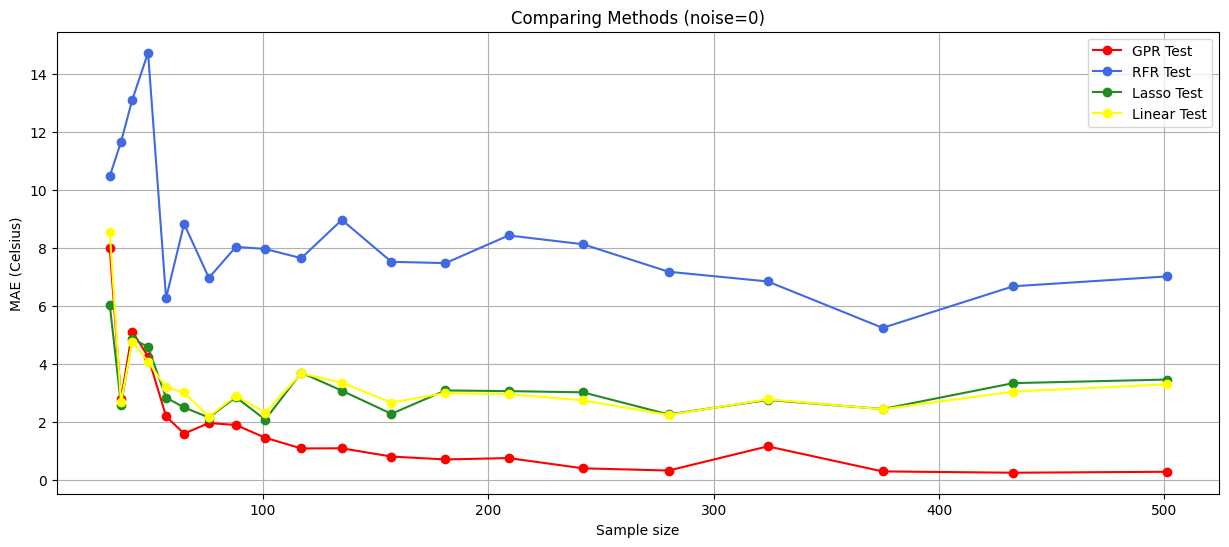

In [28]:
plt.figure(figsize=(15,6))

desired_stat = 'MAE'

if desired_stat == 'MAE':
  train_stat_1 = stats['gpr']['MAE_train']
  test_stat_1 = stats['gpr']['MAE_test']
  train_stat_2 = stats['rfr']['MAE_train']
  test_stat_2 = stats['rfr']['MAE_test']
  train_stat_3 = stats['lasso']['MAE_train']
  test_stat_3 = stats['lasso']['MAE_test']
  train_stat_4 = stats['linear']['MAE_train']
  test_stat_4 = stats['linear']['MAE_test']


if desired_stat == 'MSE':
  train_stat_1 = stats['gpr']['MSE_train']
  test_stat_1 = stats['gpr']['MSE_test']
  train_stat_2 = stats['rfr']['MSE_train']
  test_stat_2 = stats['rfr']['MSE_test']
  train_stat_3 = stats['lasso']['MSE_train']
  test_stat_3 = stats['lasso']['MSE_test']
  train_stat_4 = stats['linear']['MSE_train']
  test_stat_4 = stats['linear']['MSE_test']

if desired_stat == 'R2':
  train_stat_1 = stats['gpr']['R2_train']
  test_stat_1 = stats['gpr']['R2_test']
  train_stat_2 = stats['rfr']['R2_train']
  test_stat_2 = stats['rfr']['R2_test']
  train_stat_3 = stats['lasso']['R2_train']
  test_stat_3 = stats['lasso']['R2_test']
  train_stat_4 = stats['linear']['R2_train']
  test_stat_4 = stats['linear']['R2_test']

#plt.plot(sample_sizes, train_stat_1, 'o-', color='lightcoral', label='GPR Train')
plt.plot(sample_sizes, test_stat_1, 'o-', color='red', label='GPR Test')
#plt.plot(sample_sizes, train_stat_2, 'o-', color='cornflowerblue', label='RFR Train')
plt.plot(sample_sizes, test_stat_2, 'o-', color='royalblue', label='RFR Test')
#plt.plot(sample_sizes, train_stat_3, 'o-', color='limegreen', label='Lasso Train')
plt.plot(sample_sizes, test_stat_3, 'o-', color='forestgreen', label='Lasso Test')
#plt.plot(sample_sizes, train_stat_4, 'o-', color='limegreen', label='Linear Train')
plt.plot(sample_sizes, test_stat_4, 'o-', color='yellow', label='Linear Test')

plt.legend()
plt.grid()
plt.xlabel('Sample size')
plt.ylabel(str(desired_stat)+' (Celsius)')
plt.title('Comparing Methods (noise='+str(noise)+')')

plt.show()

# Comparing with noise for each method

In [15]:
def add_noise(df,noise_columns):
  '''
  this function adds a certain number of noise columns to the existing dataframe
  '''

  df_copy = df.copy()

  for i in range(0,noise_columns):

    df_copy['noise'+str(i)] = np.random.normal(0,1,len(df_copy))

  return(df_copy)

## FUNCTION WRITING

In [16]:
#max_sample = 300
sample_sizes = list(np.around((np.logspace(1.5, 2.7, 20)),0)) # USE LOGISTICAL SAMPLE SIZES
sample_sizes = [int(x) for x in sample_sizes]

noise = 5 # number of noise columns
stats = {}

def compare_with_noise(*models):
  """
  This function iterates through a tuple of sample_sizes to see MAE differences between those ML methods.

  Parameters

  Methods: 'RFR' / 'GPR' / 'Linear' / 'Lasso'

  Noise: # of noise variables

  """

  func_data = LHS_data.copy() # CHANGE THIS FOR LHS
  func_data = func_data.drop('simulation_values',axis=1)

  func_data_noisy = add_noise(func_data,noise)

  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()

  func_data = scaler.fit_transform(func_data)
  func_data = pd.DataFrame(func_data)

  func_data_noisy = scaler.fit_transform(func_data)
  func_data_noisy = pd.DataFrame(func_data)

  print(func_data.head())

  print(func_data_noisy.head())

  for i in models:
    stats["{0}".format(i)] = {'MAE_train':[],'MAE_test':[],'MSE_train':[],'MSE_test':[],'R2_train':[],'R2_test':[],
                              'MAE_train_noisy':[],'MAE_test_noisy':[],'MSE_train_noisy':[],'MSE_test_noisy':[],'R2_train_noisy':[],'R2_test_noisy':[]}

  print(stats.keys())

  # Changing keys for readability
  if 'GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),\n                         n_restarts_optimizer=9, normalize_y=True)' in stats:
    stats['gpr'] = stats['GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),\n                         n_restarts_optimizer=9, normalize_y=True)']
    del stats['GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),\n                         n_restarts_optimizer=9, normalize_y=True)']

  if 'RandomForestRegressor()' in stats:
    stats['rfr'] = stats['RandomForestRegressor()']
    del stats['RandomForestRegressor()']

  if 'Lasso(alpha=0.25)' in stats:
    stats['lasso'] = stats['Lasso(alpha=0.25)']
    del stats['Lasso(alpha=0.25)']

  if 'LinearRegression()' in stats:
    stats['linear'] = stats['LinearRegression()']
    del stats['LinearRegression()']

  print(stats.keys())

  for s in sample_sizes:
    indexes = random.sample(range(0, len(func_data)), s)

    sample_data = func_data.loc[indexes]
    sample_y = LHS_data['simulation_values'].loc[indexes]

    X = sample_data
    y = sample_y

    print("TTS'ing")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    print("TTS'ing complete")

    for model in models:

      model.fit(X_train, y_train)

      if str(type(model)) == "<class 'sklearn.gaussian_process._gpr.GaussianProcessRegressor'>":
        stats['gpr']['MAE_train'] += [mean_absolute_error(y_train, model.predict(X_train))]
        stats['gpr']['MAE_test'] += [mean_absolute_error(y_test, model.predict(X_test))]
        stats['gpr']['MSE_train'] += [mean_squared_error(y_train, model.predict(X_train))]
        stats['gpr']['MSE_test'] += [mean_squared_error(y_test, model.predict(X_test))]
        stats['gpr']['R2_train'] += [r2_score(y_train, model.predict(X_train))]
        stats['gpr']['R2_test'] += [r2_score(y_test, model.predict(X_test))]

        print("s: "+str(s)+ " | GPR MAE: "+str(stats['gpr']['MAE_test']))

      if str(type(model)) == "<class 'sklearn.ensemble._forest.RandomForestRegressor'>":
        stats['rfr']['MAE_train'] += [mean_absolute_error(y_train, model.predict(X_train))]
        stats['rfr']['MAE_test'] += [mean_absolute_error(y_test, model.predict(X_test))]
        stats['rfr']['MSE_train'] += [mean_squared_error(y_train, model.predict(X_train))]
        stats['rfr']['MSE_test'] += [mean_squared_error(y_test, model.predict(X_test))]
        stats['rfr']['R2_train'] += [r2_score(y_train, model.predict(X_train))]
        stats['rfr']['R2_test'] += [r2_score(y_test, model.predict(X_test))]

        print("s: "+str(s)+ " | RFR MAE: "+str(stats['rfr']['MAE_test']))

      if str(type(model)) == "<class 'sklearn.linear_model._coordinate_descent.Lasso'>":
        stats['lasso']['MAE_train'] += [mean_absolute_error(y_train, model.predict(X_train))]
        stats['lasso']['MAE_test'] += [mean_absolute_error(y_test, model.predict(X_test))]
        stats['lasso']['MSE_train'] += [mean_squared_error(y_train, model.predict(X_train))]
        stats['lasso']['MSE_test'] += [mean_squared_error(y_test, model.predict(X_test))]
        stats['lasso']['R2_train'] += [r2_score(y_train, model.predict(X_train))]
        stats['lasso']['R2_test'] += [r2_score(y_test, model.predict(X_test))]

        print("s: "+str(s)+ " | LASSO MAE: "+str(stats['lasso']['MAE_test']))

      if str(type(model)) == "<class 'sklearn.linear_model._base.LinearRegression'>":
        stats['linear']['MAE_train'] += [mean_absolute_error(y_train, model.predict(X_train))]
        stats['linear']['MAE_test'] += [mean_absolute_error(y_test, model.predict(X_test))]
        stats['linear']['MSE_train'] += [mean_squared_error(y_train, model.predict(X_train))]
        stats['linear']['MSE_test'] += [mean_squared_error(y_test, model.predict(X_test))]
        stats['linear']['R2_train'] += [r2_score(y_train, model.predict(X_train))]
        stats['linear']['R2_test'] += [r2_score(y_test, model.predict(X_test))]

        print("s: "+str(s)+ " | LINEAR MAE: "+str(stats['linear']['MAE_test']))


    # ---
    # Same thing now, for noisy data
    # ---

    # use same indexes

    noisy_sample_data = func_data_noisy.loc[indexes] # NOISY DATA
    sample_y = LHS_data['simulation_values'].loc[indexes]

    X_noisy = noisy_sample_data
    y_noisy = sample_y.copy()

    print("TTS'ing noisy")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    print("TTS'ing noisy complete")

    for model in models:

      model.fit(X_train, y_train)

      if str(type(model)) == "<class 'sklearn.gaussian_process._gpr.GaussianProcessRegressor'>":
        stats['gpr']['MAE_train_noisy'] += [mean_absolute_error(y_train, model.predict(X_train))]
        stats['gpr']['MAE_test_noisy'] += [mean_absolute_error(y_test, model.predict(X_test))]
        stats['gpr']['MSE_train_noisy'] += [mean_squared_error(y_train, model.predict(X_train))]
        stats['gpr']['MSE_test_noisy'] += [mean_squared_error(y_test, model.predict(X_test))]
        stats['gpr']['R2_train_noisy'] += [r2_score(y_train, model.predict(X_train))]
        stats['gpr']['R2_test_noisy'] += [r2_score(y_test, model.predict(X_test))]

        print("s: "+str(s)+ " | GPR MAE_noisy: "+str(stats['gpr']['MAE_test_noisy']))

      if str(type(model)) == "<class 'sklearn.ensemble._forest.RandomForestRegressor'>":
        stats['rfr']['MAE_train_noisy'] += [mean_absolute_error(y_train, model.predict(X_train))]
        stats['rfr']['MAE_test_noisy'] += [mean_absolute_error(y_test, model.predict(X_test))]
        stats['rfr']['MSE_train_noisy'] += [mean_squared_error(y_train, model.predict(X_train))]
        stats['rfr']['MSE_test_noisy'] += [mean_squared_error(y_test, model.predict(X_test))]
        stats['rfr']['R2_train_noisy'] += [r2_score(y_train, model.predict(X_train))]
        stats['rfr']['R2_test_noisy'] += [r2_score(y_test, model.predict(X_test))]

        print("s: "+str(s)+ " | RFR MAE_noisy: "+str(stats['rfr']['MAE_test_noisy']))

      if str(type(model)) == "<class 'sklearn.linear_model._coordinate_descent.Lasso'>":
        stats['lasso']['MAE_train_noisy'] += [mean_absolute_error(y_train, model.predict(X_train))]
        stats['lasso']['MAE_test_noisy'] += [mean_absolute_error(y_test, model.predict(X_test))]
        stats['lasso']['MSE_train_noisy'] += [mean_squared_error(y_train, model.predict(X_train))]
        stats['lasso']['MSE_test_noisy'] += [mean_squared_error(y_test, model.predict(X_test))]
        stats['lasso']['R2_train_noisy'] += [r2_score(y_train, model.predict(X_train))]
        stats['lasso']['R2_test_noisy'] += [r2_score(y_test, model.predict(X_test))]

        print("s: "+str(s)+ " | LASSO MAE_noisy: "+str(stats['lasso']['MAE_test_noisy']))

      if str(type(model)) == "<class 'sklearn.linear_model._base.LinearRegression'>":
        stats['linear']['MAE_train_noisy'] += [mean_absolute_error(y_train, model.predict(X_train))]
        stats['linear']['MAE_test_noisy'] += [mean_absolute_error(y_test, model.predict(X_test))]
        stats['linear']['MSE_train_noisy'] += [mean_squared_error(y_train, model.predict(X_train))]
        stats['linear']['MSE_test_noisy'] += [mean_squared_error(y_test, model.predict(X_test))]
        stats['linear']['R2_train_noisy'] += [r2_score(y_train, model.predict(X_train))]
        stats['linear']['R2_test_noisy'] += [r2_score(y_test, model.predict(X_test))]

        print("s: "+str(s)+ " | LINEAR MAE_noisy: "+str(stats['linear']['MAE_test_noisy']))

  return stats

## Executing Function

In [17]:
compare_with_noise(lasso,gpr,rfr,linear)

         0         1         2         3         4         5         6   \
0  0.622121  0.770482  0.128782 -1.270622  1.325441 -0.250616  0.080252   
1 -1.537214  1.338254 -0.115767 -1.016596  0.702756  1.526313 -1.506268   
2  1.404316  1.656889 -1.130376  0.239153 -1.036951 -1.474244  0.939529   
3 -1.020284 -0.371087 -1.425944  1.304388  0.158297  1.466502  1.480812   
4 -1.401658  1.308818 -1.411717  0.134198 -0.177030  0.924527  0.573897   

         7         8         9         10        11        12        13  
0 -0.044270  1.290301  0.951284 -0.866874 -0.487935 -0.769453 -0.923270  
1  1.435107  0.773109 -0.029636 -1.655318 -1.477415  0.555992 -0.242785  
2  0.913607  1.125652 -1.053974 -1.435034  0.291144 -0.589935  0.826785  
3 -1.544772 -1.647529  1.499506  0.857989  0.878701  1.689476  1.166878  
4 -1.461285  1.207808  0.799788 -0.297624 -1.021166  1.721492  0.925929  
         0         1         2         3         4         5         6   \
0  0.622121  0.770482  0.12878

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


s: 501 | GPR MAE: [4.796769735871886, 3.952338416237545, 2.742571357886814, 2.602315093157216, 1.983147187648432, 1.8923083705246357, 1.848739862266239, 2.0490433103208137, 1.6941613817128367, 1.8738407936989627, 1.3872464168917398, 1.0877803685798444, 0.5441168872903259, 0.6662662520480589, 0.45846509294467314, 0.30208152679166844, 1.1367733764900882, 0.2930012075209682, 0.2556243714589321, 0.2382441489128308]
s: 501 | RFR MAE: [12.127034115469248, 7.787872166791686, 11.166424997721183, 8.120866726802138, 9.27110621564436, 8.06723102175156, 11.84547825729366, 7.1367415596949115, 7.851296731588656, 8.157240072299636, 6.4594858599266, 9.179909071220713, 7.631175324827038, 7.98222543716534, 6.241839711830448, 6.857985629335671, 6.361425637617421, 5.401414768879684, 6.649621265855994, 6.539136530965959]
s: 501 | LINEAR MAE: [5.551672605454273, 6.0801833316777945, 2.118771862343566, 2.4891107106202357, 1.4080816171000095, 2.029137203660066, 2.510507498532796, 3.0025655766917194, 3.03521513

{'gpr': {'MAE_train': [5.012020665162708e-09,
   6.253910982948206e-09,
   7.0065335890059504e-09,
   9.294486365737006e-09,
   7.865100491876041e-09,
   7.392484436562741e-09,
   6.588589940292877e-09,
   1.2717012915735333e-08,
   1.5782196527425187e-08,
   1.2030062451583123e-08,
   1.7564319579024513e-08,
   2.5941779767890692e-08,
   3.850082682295882e-08,
   5.256069612813574e-08,
   6.099296988254136e-08,
   6.63249270108476e-08,
   2.70374242565707e-08,
   1.1139389850238028e-07,
   1.0622844641179365e-07,
   1.2648338540088844e-07],
  'MAE_test': [4.796769735871886,
   3.952338416237545,
   2.742571357886814,
   2.602315093157216,
   1.983147187648432,
   1.8923083705246357,
   1.848739862266239,
   2.0490433103208137,
   1.6941613817128367,
   1.8738407936989627,
   1.3872464168917398,
   1.0877803685798444,
   0.5441168872903259,
   0.6662662520480589,
   0.45846509294467314,
   0.30208152679166844,
   1.1367733764900882,
   0.2930012075209682,
   0.2556243714589321,
   0.23

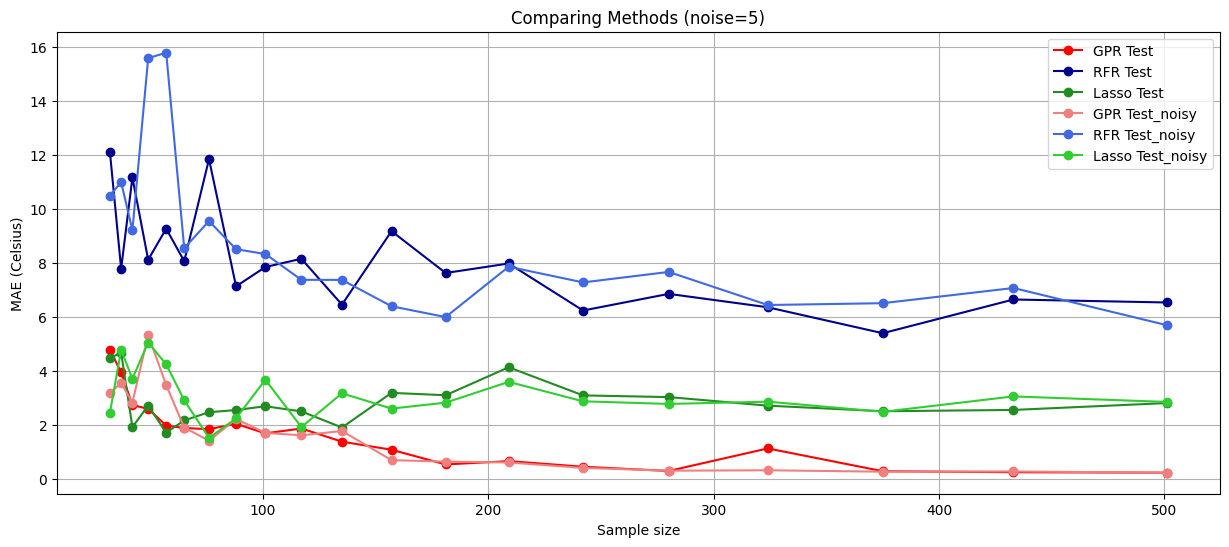

In [18]:
plt.figure(figsize=(15,6))

desired_stat = 'MAE'

if desired_stat == 'MAE':
  test_stat_1 = stats['gpr']['MAE_test']
  noisy_test_stat_1 = stats['gpr']['MAE_test_noisy']
  test_stat_2 = stats['rfr']['MAE_test']
  noisy_test_stat_2 = stats['rfr']['MAE_test_noisy']
  test_stat_3 = stats['lasso']['MAE_test']
  noisy_test_stat_3 = stats['lasso']['MAE_test_noisy']
  test_stat_4 = stats['linear']['MAE_test']
  noisy_test_stat_4 = stats['linear']['MAE_test_noisy']

plt.plot(sample_sizes, test_stat_1, 'o-', color='red', label='GPR Test')
plt.plot(sample_sizes, test_stat_2, 'o-', color='darkblue', label='RFR Test')
plt.plot(sample_sizes, test_stat_3, 'o-', color='forestgreen', label='Lasso Test')
#plt.plot(sample_sizes, test_stat_4, 'o-', color='darkviolet', label='Linear Test')

# Lighter colors for noisy ones

plt.plot(sample_sizes, noisy_test_stat_1, 'o-', color='lightcoral', label='GPR Test_noisy')
plt.plot(sample_sizes, noisy_test_stat_2, 'o-', color='royalblue', label='RFR Test_noisy')
plt.plot(sample_sizes, noisy_test_stat_3, 'o-', color='limegreen', label='Lasso Test_noisy')
#plt.plot(sample_sizes, noisy_test_stat_4, 'o-', color='plum', label='Linear Test_noisy')


plt.legend()
plt.grid()
plt.xlabel('Sample size')
plt.ylabel(str(desired_stat)+' (Celsius)')
plt.title('Comparing Methods (noise='+str(noise)+')')

plt.show()